<a href="https://colab.research.google.com/github/Reyuliandespa/Reyuliandespa/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                               
import pandas as pd                             
import matplotlib.pyplot as plt                
import seaborn as sns                           
from scipy.optimize import minimize   

In [ ]:
df=pd.read_csv("/dataset-test.csv",sep=';',parse_dates=['date'], index_col='date')
df.head()

,order_qty,product_id,store
date,,,
2016-08-01,0,G7,7082
2016-08-01,1,B2,7081
2016-08-01,1,E5,7079
2016-08-01,1,B2,7081
2016-08-01,0,G7,7082


In [ ]:
df.tail()

,order_qty,product_id,store
date,,,
2018-12-01,0,F6,7079
2018-12-01,0,C3,7082
2018-12-01,1,C3,7082
2018-12-01,0,C3,7082
2018-12-01,1,C3,7082


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17121 entries, 2016-08-01 to 2018-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   order_qty   17121 non-null  int64 
 1   product_id  17121 non-null  object
 2   store       17121 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 535.0+ KB


In [ ]:
df.describe()

,order_qty,store
count,17121.000000,17121.000000
mean,0.573156,7080.376555
std,1.487538,2.353007
min,0.000000,7079.000000
25%,0.000000,7079.000000
50%,0.000000,7079.000000
75%,1.000000,7081.000000
max,25.000000,7088.000000


In [ ]:
df.shape

(17121, 3)

In [ ]:
#Data Untuk Store dengan Kode 7079
df79  = df[df.loc[:,'store']==7079]
df79.head()

,order_qty,product_id,store
date,,,
2016-08-01,1,E5,7079
2016-08-01,1,E5,7079
2016-08-01,0,E5,7079
2016-08-01,6,E5,7079
2016-08-01,3,E5,7079


In [ ]:
df79.shape

(10025, 3)

In [ ]:
data79=pd.pivot_table(df79, index=['date'], columns=['product_id'] ,aggfunc={'order_qty':sum}, fill_value=0)
data79

order_qty         
product_id        A1   E5  F6
date                         
2016-08-01         0  124   0
2016-08-02         0    0   0
2016-08-03         0    2   0
2016-08-04         0    0   0
2016-08-05         0    2   0
...              ...  ...  ..
2018-11-23         0    0   0
2018-11-26         0    0   4
2018-11-27         0    0   2
2018-11-28         0    0   0
2018-12-01         1    0  10

[577 rows x 3 columns]

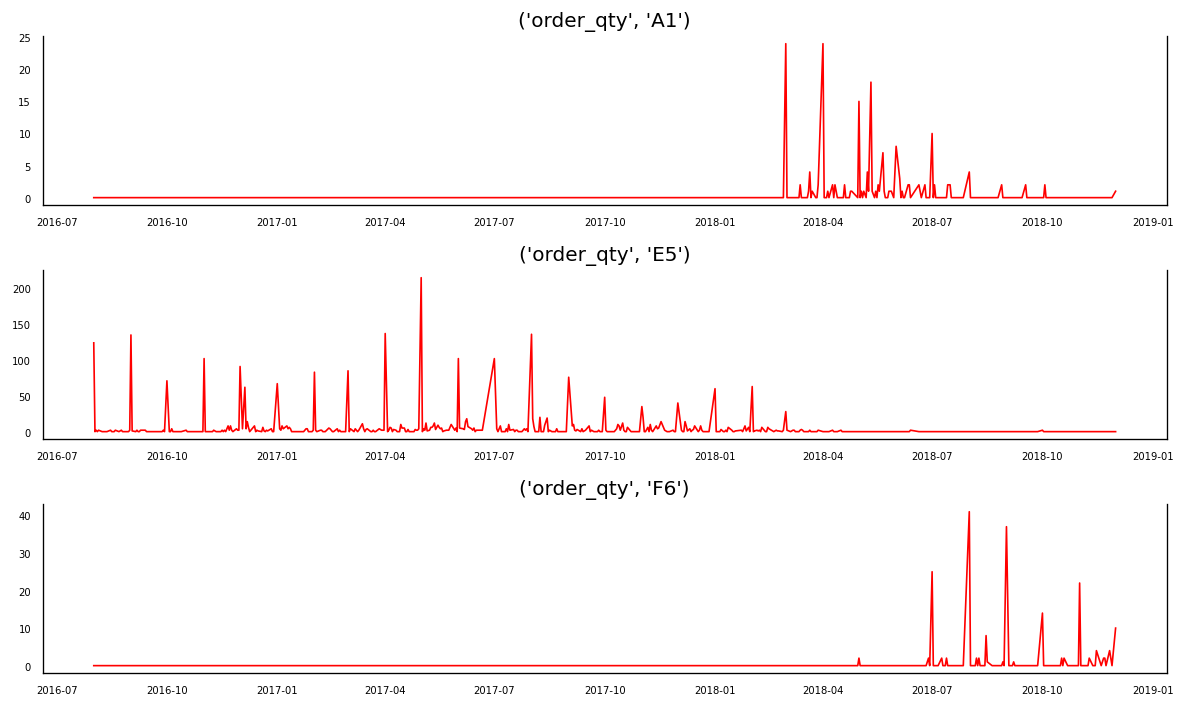

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = data79[data79.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(data79.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#Menjumlahkan Order_qty untuk setiap tanggal tanpa memperhatikan kode produk
df79_all  = pd.DataFrame(df79['order_qty'])
df79_all.head()

,order_qty
date,
2016-08-01,1
2016-08-01,1
2016-08-01,0
2016-08-01,6
2016-08-01,3


In [ ]:
# total order quantity
df79_all=df79_all.groupby("date").order_qty.sum()
df79_all = pd.DataFrame(df79_all)
df79_all.columns = ["sales_qty"]
df79_all["sales_qty"]=df79_all["sales_qty"]+10
df79_all.head()

,sales_qty
date,
2016-08-01,134
2016-08-02,10
2016-08-03,12
2016-08-04,10
2016-08-05,12


In [ ]:
df79_all.shape

(577, 1)

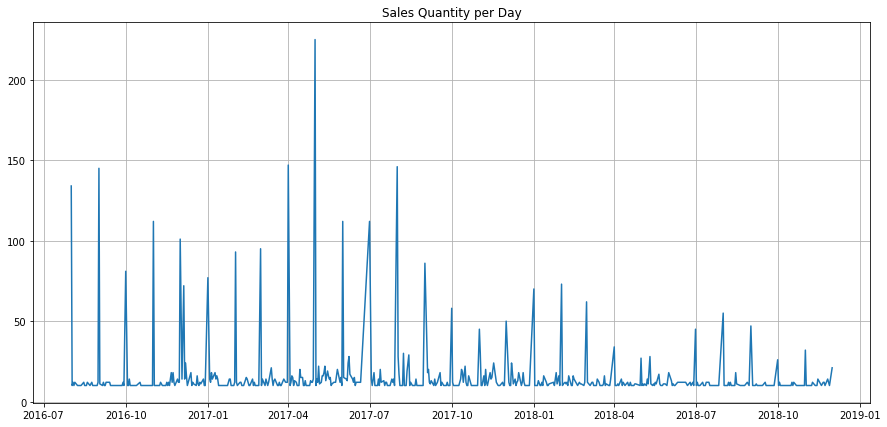

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df79_all.sales_qty)
plt.title('Sales Quantity per Day')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time Series Cross Validation 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=30):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
%%time
data = df79_all.sales_qty[:-57] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 30 days
model = HoltWinters(data, slen = 30, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 87, scaling_factor = 3)
model.triple_exponential_smoothing()

0.7596292309952235 0.0 0.47362164548540653
CPU times: user 2.86 s, sys: 11.6 ms, total: 2.87 s
Wall time: 2.85 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error_in= mean_absolute_percentage_error(series.values[:490], model.result[:490])
    error_out= mean_absolute_percentage_error(series.values[490:], model.result[490:len(series)])
    plt.title("Mean Absolute Percentage Error for Data Train: {0:.2f}% and Mean Absolute Percentage Error for Data Test: {1:.2f}%".format(error_in,error_out))

    

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-57, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

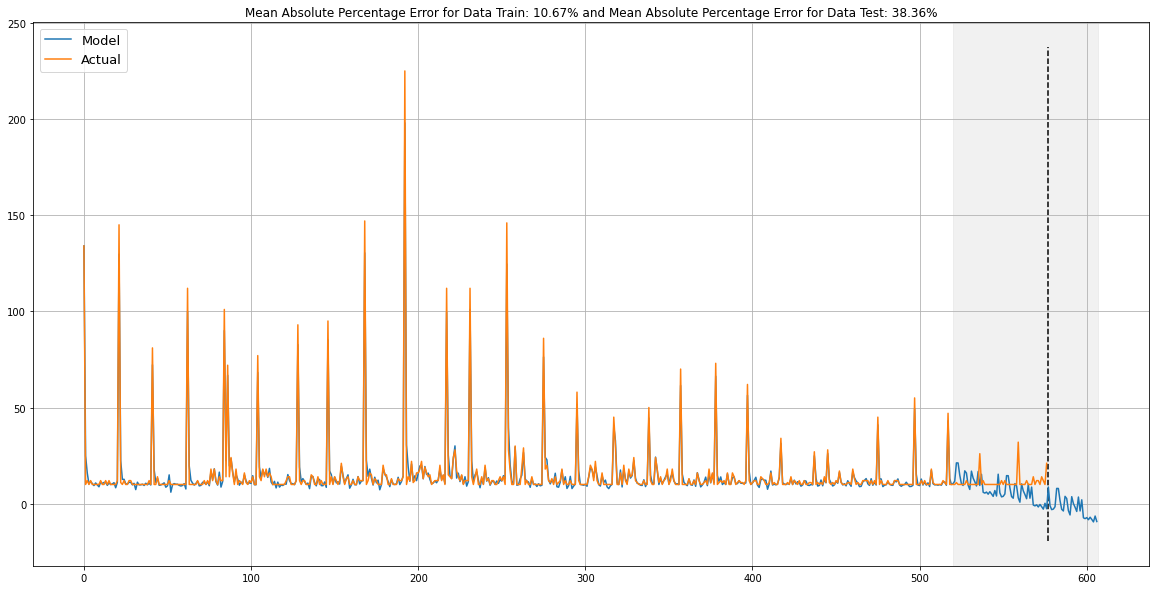

In [ ]:
plotHoltWinters(df79_all.sales_qty)

## Product_ID A1

In [ ]:
A1  = df79[df79.loc[:,'product_id']!="F6"]
A1  = pd.DataFrame(A1['order_qty'])
A1.head(10)

,order_qty
date,
2016-08-01,1
2016-08-01,1
2016-08-01,0
2016-08-01,6
2016-08-01,3
2016-08-01,0
2016-08-01,0
2016-08-01,5
2016-08-01,2


In [ ]:
A1.shape

(9498, 1)

In [ ]:
# total order quantity
A1=A1.groupby("date").order_qty.sum()
A1 = pd.DataFrame(A1)
A1.columns = ["sales_qty"]
A1.head()

,sales_qty
date,
2016-08-01,124
2016-08-02,0
2016-08-03,2
2016-08-04,0
2016-08-05,2


In [ ]:
A1["sales_qty"] = A1["sales_qty"]+10
A1.tail()

,sales_qty
date,
2018-10-11,10
2018-10-12,10
2018-11-12,10
2018-11-22,10
2018-12-01,11


In [ ]:
A1.shape

(548, 1)

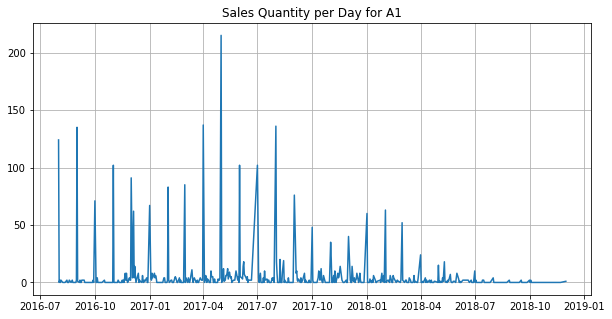

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(A1.sales_qty)
plt.title('Sales Quantity per Day for A1')
plt.grid(True)
plt.show()

In [ ]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=30):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
%%time
data = A1.sales_qty[:-54] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 30 days
model = HoltWinters(data, slen = 30, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 84, scaling_factor = 3)
model.triple_exponential_smoothing()

0.34284249264627503 0.0 0.27107461086472295
CPU times: user 4.77 s, sys: 20.2 ms, total: 4.79 s
Wall time: 4.79 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(pd.Series(model.result)-10, label = "Model")
    plt.plot(pd.Series(series.values)-10, label = "Actual")
    error_in= mean_absolute_percentage_error(series.values[:494], model.result[:494])
    error_out= mean_absolute_percentage_error(series.values[494:], model.result[494:len(series)])
    plt.title("Mean Absolute Percentage Error for Data Train: {0:.2f}% and Mean Absolute Percentage Error for Data Test: {1:.2f}%".format(error_in,error_out))

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-54, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


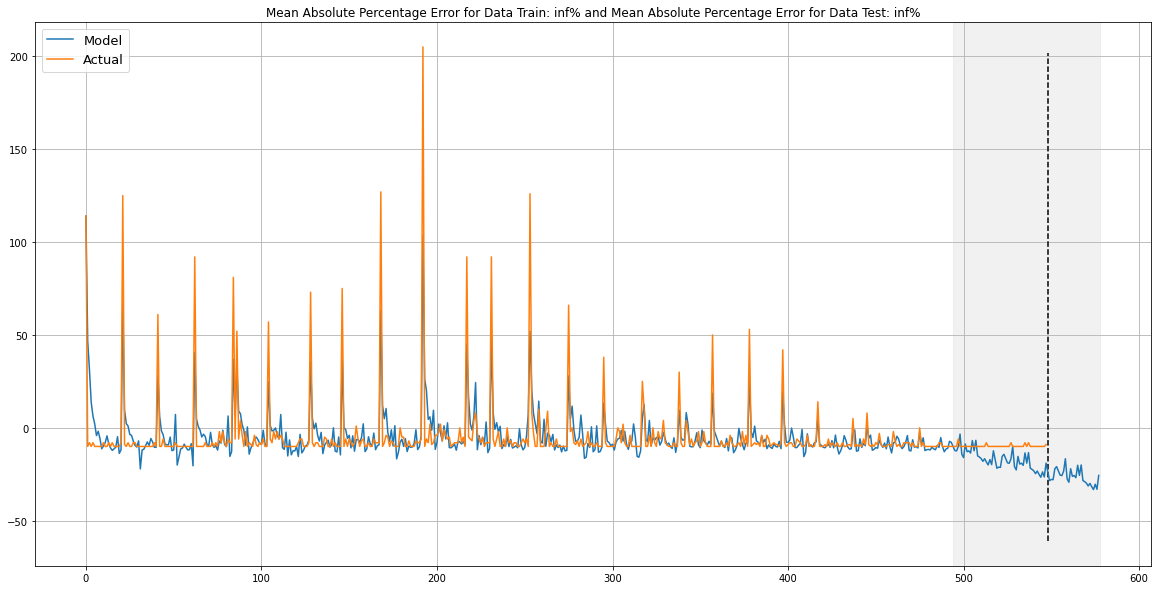

In [ ]:
plotHoltWinters(A1.sales_qty)

In [ ]:
def MSE(y_true, y_pred): 
    return np.mean((y_true - y_pred)**2)

In [ ]:
MSE(A1.sales_qty[494:], model.result[494:548])

76.5862148886496

In [ ]:
np.sqrt(MSE(A1.sales_qty[494:], model.result[494:548]))

8.75135503157366

## Product F6

In [ ]:
F6  = df79[df79.loc[:,'product_id']!="A1"]
F6  = pd.DataFrame(F6['order_qty'])
F6.head(10)

,order_qty
date,
2016-08-01,1
2016-08-01,1
2016-08-01,0
2016-08-01,6
2016-08-01,3
2016-08-01,0
2016-08-01,0
2016-08-01,5
2016-08-01,2


In [ ]:
F6.shape

(8775, 1)

In [ ]:
# total order quantity
F6=F6.groupby("date").order_qty.sum()
F6 = pd.DataFrame(F6)
F6.columns = ["sales_qty"]
F6.head()

,sales_qty
date,
2016-08-01,124
2016-08-02,0
2016-08-03,2
2016-08-04,0
2016-08-05,2


In [ ]:
F6["sales_qty"] = F6["sales_qty"]+10
F6.tail()

,sales_qty
date,
2018-11-23,10
2018-11-26,14
2018-11-27,12
2018-11-28,10
2018-12-01,20


In [ ]:
F6.shape

(491, 1)

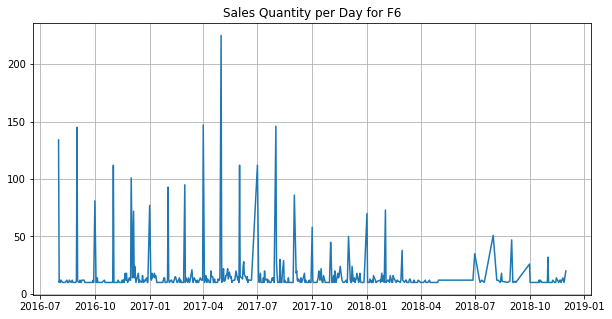

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(F6.sales_qty)
plt.title('Sales Quantity per Day for F6')
plt.grid(True)
plt.show()

In [ ]:
%%time
data = F6.sales_qty[:-49] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 30 days
model = HoltWinters(data, slen = 30, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 79, scaling_factor = 3)
model.triple_exponential_smoothing()

0.1371131341316461 0.0 0.07063731012081059
CPU times: user 4.55 s, sys: 30.9 ms, total: 4.58 s
Wall time: 4.58 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(pd.Series(model.result)-10, label = "Model")
    plt.plot(pd.Series(series.values), label = "Actual")
    error_in= mean_absolute_percentage_error(series.values[:442], model.result[:442])
    error_out= mean_absolute_percentage_error(series.values[442:], model.result[442:len(series)])
    plt.title("Mean Absolute Percentage Error for Data Train: {0:.2f}% and Mean Absolute Percentage Error for Data Test: {1:.2f}%".format(error_in,error_out))

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-49, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

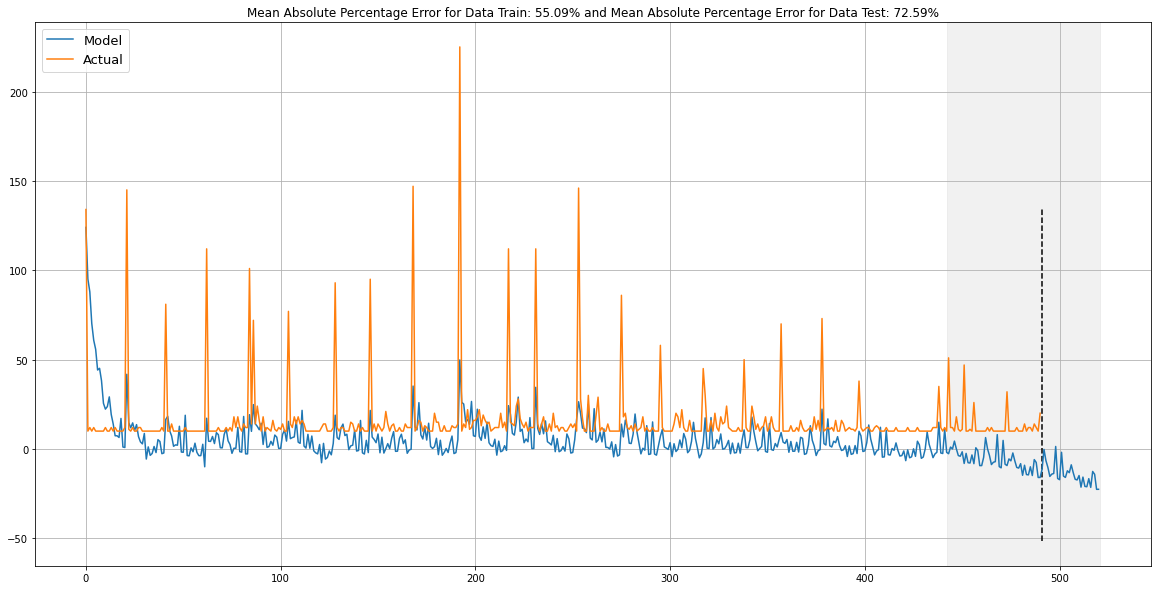

In [ ]:
plotHoltWinters(F6.sales_qty)

In [ ]:
MSE(F6.sales_qty[442:], model.result[442:491])

192.76010492930632

In [ ]:
np.sqrt(MSE(F6.sales_qty[442:], model.result[442:491]))

13.883807292285006